# bond_angle_scan - Methodology and code

__Python imports__

- [numpy](http://www.numpy.org/)
- [IPython](https://ipython.org)
- [atomman](https://github.com/usnistgov/atomman)
- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from pathlib import Path
import datetime
from math import floor
from typing import Optional

# http://www.numpy.org/
import numpy as np

# https://ipython.org/
from IPython.display import display, Markdown

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc
from atomman.tools import filltemplate, aslist

# https://github.com/usnistgov/iprPy
import iprPy
from iprPy.tools import read_calc_file

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2024-05-02 using iprPy version 0.11.7


## 1. Load calculation and view description

### 1.1. Load the calculation

In [2]:
# Load the calculation being demoed
calculation = iprPy.load_calculation('bond_angle_scan')

### 1.2. Display calculation description and theory

In [3]:
# Display main docs and theory
display(Markdown(calculation.maindoc))
display(Markdown(calculation.theorydoc))

# bond_angle_scan calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

## Introduction

The bond_angle_scan calculation style evaluates the interaction energy between three atoms at varying distances and angles.  This provides a means of characterizing the three-body interactions of a given potential.  These interactions can provide insight into the bonding predictions for a potential as well as a means of fingerprinting the potentials.

### Version notes

- 2021-04-XX: Calculation added

### Additional dependencies

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)


## Method and Theory

Three atoms are placed in an otherwise empty system.  The relative positions of the atoms are determined by the following three coordinates

- r_ij is the radial distance between atoms i and j,
- r_ik is the radial distance between atoms i and k, and
- theta_ijk is the angle formed between the i-j and i-k vectors.

Based on these three bond coordinates, the full positions of the three atoms in the system are determined as follows

- Atom i is positioned at the system's origin, [0, 0, 0]
- Atom j is placed r_ij away from atom i along the x coordinate, [r_ij, 0.0, 0.0]
- Atom k is placed in the xy plane based on r_ik and theta_ijk, [r_ik cos(theta_ijk), r_ik sin(theta_ijk), 0.0]

Values of r_ij, r_ik and theta_ijk are iterated over. The potential energy of the three atoms is evaluated for each configuration corresponding to the different coordinate sets.


## 2. Define calculation functions and generate files

This section defines the calculation functions and associated resource files exactly as they exist inside the iprPy package.  This allows for the code used to be directly visible and modifiable by anyone looking to see how it works.

### 2.1. bond_angle_scan()

This is the primary function for the calculation.  The version of this function built in iprPy can be accessed by calling the calc() method of an object of the associated calculation class.

In [4]:
def bond_angle_scan(lammps_command: str,
                    potential: am.lammps.Potential, 
                    symbols: list,
                    mpi_command: Optional[str] = None,
                    rmin: float = uc.set_in_units(0.5, 'angstrom'), 
                    rmax: float = uc.set_in_units(6.0, 'angstrom'), 
                    rnum: int = 100,
                    thetamin: float = 1.0,
                    thetamax: float = 180,
                    thetanum: int = 100) -> dict:
    """
    Performs a three-body bond angle energy scan over a range of interatomic
    spaces, r, and angles, theta.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    symbols : list
        The potential symbols associated with the three atoms in the cluster.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    rmin : float, optional
        The minimum value for the r_ij and r_ik spacings. Default value is 0.5.
    rmax : float, optional
        The maximum value for the r_ij and r_ik spacings. Default value is 5.5.
    rnum : int, optional
        The number of r_ij and r_ik spacings to evaluate. Default value is 100.
    thetamin : float, optional
        The minimum value for the theta angle. Default value is 1.0.
    thetamax : float, optional
        The maximum value for the theta angle. Default value is 180.0.
    thetanum : int, optional
        The number of theta angles to evaluate. Default value is 100.
        
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'cluster'** (*atomman.cluster.BondAngleMap*) - Object that maps
          measured energies to r, theta coordinates, and contains built-in
          analysis tools.
        - **results_file'** (*str*) - File name containing the raw energy
          scan results.
        - **'length_unit'** (*str*) - Unit of length used in the results_file.
        - **'energy_unit'** (*str*) - Unit of energy used in the results_file.
    """
 
    # Create cluster object
    cluster = am.cluster.BondAngleMap(rmin=rmin, rmax=rmax, rnum=rnum,
                                      thetamin=thetamin, thetamax=thetamax,
                                      thetanum=thetanum, symbols=symbols)
    
    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
    
    # Define lammps variables
    lammps_variables = {}
    
    # Add range parameters
    lammps_variables['rmin'] = uc.get_in_units(rmin, lammps_units['length'])
    lammps_variables['rmax'] = uc.get_in_units(rmax, lammps_units['length'])
    lammps_variables['rnum'] = uc.get_in_units(rnum, lammps_units['length'])
    lammps_variables['thetamin'] = thetamin
    lammps_variables['thetamax'] = thetamax
    lammps_variables['thetanum'] = thetanum

    # Add atomic types
    if len(cluster.symbols) == 1:
        natypes = 1
        atype = np.array([1,1,1])
        symbols = cluster.symbols
    elif len(cluster.symbols) == 3:
        symbols, atype = np.unique(cluster.symbols, return_inverse=True)
        atype += 1
        natypes = len(symbols) 
    lammps_variables['natypes'] = natypes
    lammps_variables['atype1'] = atype[0]
    lammps_variables['atype2'] = atype[1]
    lammps_variables['atype3'] = atype[2]
    
    # Add potential information
    lammps_variables['atomman_pair_info'] = potential.pair_info(symbols)
    lammps_variables['atom_style'] = potential.atom_style
    lammps_variables['units'] = potential.units

    # Build lammps input script
    lammps_script = 'bond_scan.in'
    template = read_calc_file('iprPy.calculation.bond_angle_scan', 'bond_scan.template')
    with open(lammps_script, 'w') as f:
        f.write(filltemplate(template, lammps_variables, '<', '>'))
    
    # Run lammps and extract data
    lmp.run(lammps_command, script_name=lammps_script, mpi_command=mpi_command, logfile=None, screen=False)
    cluster.load_table('3_body_scan.txt', length_unit=lammps_units['length'],
                       energy_unit=lammps_units['energy'])
    
    # Collect results
    results_dict = {}
    results_dict['cluster'] = cluster
    results_dict['results_file'] = '3_body_scan.txt'
    results_dict['length_unit'] = lammps_units['length']
    results_dict['energy_unit'] = lammps_units['energy']
    
    return results_dict

### 2.2. bond_scan.template file

In [5]:
with open('bond_scan.template', 'w') as f:
    f.write("""# LAMMPS input script for exploring the three-body phase space

# Specify loop ranges
variable rmin equal <rmin>
variable rmax equal <rmax>
variable rnum equal <rnum>
variable thetamin equal <thetamin>
variable thetamax equal <thetamax>
variable thetanum equal <thetanum>

# Define dummy values for loop indices
#variable i equal 1
#variable j equal 1
#variable k equal 1

# Define variable atom coordinates
variable rij equal ${rmin}+(v_i-1)*(${rmax}-${rmin})/(${rnum}-1)
variable rik equal ${rmin}+(v_j-1)*(${rmax}-${rmin})/(${rnum}-1)
variable theta equal ${thetamin}+(v_k-1)*(${thetamax}-${thetamin})/(${thetanum}-1)
variable rtheta equal v_theta*PI/180.0
variable j_x equal v_rij
variable k_x equal v_rik*cos(v_rtheta)
variable k_y equal v_rik*sin(v_rtheta)
variable energy equal pe

# Define box bounds based on rmax
variable rlo equal -3*${rmax}
variable rhi equal 3*${rmax}

units <units>

atom_style <atom_style>

boundary f f f

region rbox block ${rlo} ${rhi} ${rlo} ${rhi} -1.0 1.0

create_box <natypes> rbox

<atomman_pair_info>

thermo_style custom step pe
thermo_modify format float %.13e

# Create atom 1
create_atoms <atype1> single 0.0 0.0 0.0 units box

# Start 3_body_scan.txt with header fields
print "${rmin} ${rmax} ${rnum}" file 3_body_scan.txt screen no
print "${rmin} ${rmax} ${rnum}" append 3_body_scan.txt screen no
print "${thetamin} ${thetamax} ${thetanum}" append 3_body_scan.txt screen no

# Loop i over r_ij values
variable i loop ${rnum}
    label loopi

    # Create atom 2
    create_atoms <atype2> single ${j_x} 0.0 0.0 units box
    group id2 id 2

    # Loop j over r_ik values
    variable j loop ${rnum}
        label loopj
        
        # Loop k over theta values
        variable k loop ${thetanum}
            label loopk

            # Create atom 3
            create_atoms <atype3> single ${k_x} ${k_y} 0.0 units box
            group id3 id 3

            # Compute energy and output it to 3_body_scan.txt
            run 0
            print "${i} ${j} ${k} ${energy}" append 3_body_scan.txt screen no
            delete_atoms group id3

            next k
            jump bond_scan.in loopk
            
        next j
        jump bond_scan.in loopj

    delete_atoms group id2
    next i
    jump bond_scan.in loopi""")

## 3. Specify input parameters

### 3.1. System-specific paths

- __lammps_command__ is the LAMMPS command to use (required).
- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

In [6]:
lammps_command = '/home/lmh1/LAMMPS/2022-06-23/src/lmp_serial'
mpi_command = None

# Optional: check that LAMMPS works and show its version 
print(f'LAMMPS version = {am.lammps.checkversion(lammps_command)["version"]}')

LAMMPS version = 23 Jun 2022


### 3.2. Interatomic potential

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for the calculation.  
- __potential__ is an atomman.lammps.Potential object (required).

In [7]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

# Retrieve potential and parameter file(s) using atomman
potential = am.load_lammps_potential(id=potential_name, getfiles=True)

#### 2.3. Calculation-specific parameters

- __symbols__ is the element or set of three element model symbols to use for the cluster.
- __rmin__ is the minimum r_ij and r_ik spacing to use.
- __rmax__ is the maximum r_ij and r_ik spacing to use.
- __rnum__ is the number of r_ij and r_ik spacing steps to evaluate.

- __thetamin__ is the minimum theta angle to use.
- __thetamax__ is the maximum theta angle to use.
- __thetanum__ is the number of theta angle steps to evaluate.

In [8]:
symbols = 'Ni'

rmin = uc.set_in_units(0.02, 'angstrom')
rmax = uc.set_in_units(6.0, 'angstrom')
rnum = 20

thetamin = 1.0
thetamax = 180.0
thetanum = 20

## 4. Run calculation and view results

### 4.1. Run calculation

All primary calculation method functions take a series of inputs and return a dictionary of outputs.

In [9]:
results_dict = bond_angle_scan(lammps_command, potential, symbols, mpi_command = mpi_command,
                                rmin = rmin, rmax = rmax, rnum = rnum,
                                thetamin = thetamin, thetamax = thetamax, thetanum = thetanum)
print(results_dict.keys())

dict_keys(['cluster', 'results_file', 'length_unit', 'energy_unit'])


### 4.2. Report results

Values returned in the results_dict:
- **'cluster'** (*atomman.cluster.BondAngleMap*) - An object containing the evaluated energies and their coordinates.  Includes built-in methods for analyzing the results.
- **'results_file'** (*str*) - The name of the file where the measured energies are saved.
- **'length_unit'** (*str*) - The unit of length used in results_file.
- **'energy_unit'** (*str*) - The unit of energy used in results_file.

In [10]:
print('Results are saved in', results_dict['results_file'])
print('with lengths in', results_dict['length_unit'])
print('and energies in', results_dict['energy_unit'])

Results are saved in 3_body_scan.txt
with lengths in angstrom
and energies in eV


In [11]:
cluster = results_dict['cluster']

cluster.df

,r_ij,r_ik,r_jk,theta,energy
0,0.02,0.02,0.000349,1.000000,9.662228e+02
1,0.02,0.02,0.003633,10.421053,9.644323e+02
2,0.02,0.02,0.006892,19.842105,9.626081e+02
3,0.02,0.02,0.010104,29.263158,9.608158e+02
4,0.02,0.02,0.013248,38.684211,9.590673e+02
...,...,...,...,...,...
7995,6.00,6.00,11.356946,142.315789,-9.291009e-11
7996,6.00,6.00,11.636851,151.736842,-9.291009e-11
7997,6.00,6.00,11.838145,161.157895,-9.291009e-11
7998,6.00,6.00,11.959468,170.578947,-9.291009e-11


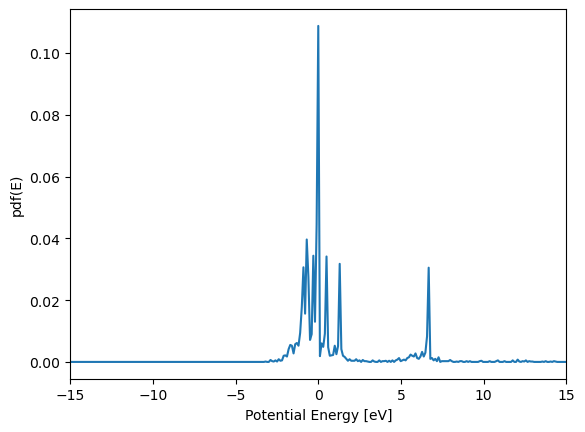

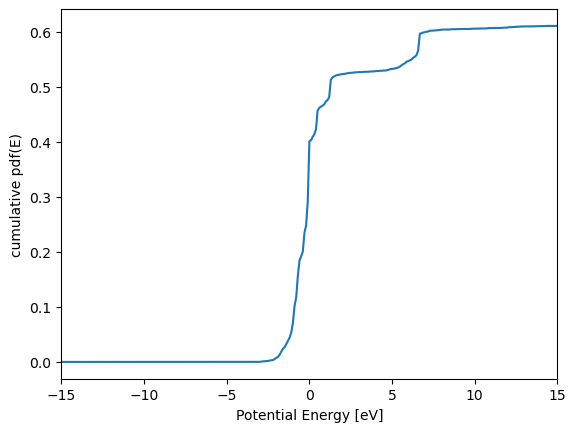

In [12]:
cluster.plot_pdf()
cluster.plot_cumulative_pdf()
None